In [1]:
""" revenue in millions """

' revenue in millions '

In [2]:
import tqdm
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [3]:
print(tf.__version__)

2.8.0


In [4]:
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers
from keras.models import Sequential

In [5]:
from utils import cd_root_dir, sin_transformer, cos_transformer, save2Vis, pl_residual, pl_residual_horizontal, pl_residual_hist
from modules import pl_preds_uncertainty, plot_history_info, EnsemblePredict, cp_dp_PI_bound, show_dist, AleatoricPredict
from models import build_and_compile_model, create_and_compile_aleatoric_model, build_lstm, compile_and_fit_lstm, build_BLSTM_svi
from pipeline import import_data, base_process_data, feature_normalization, ensemble_predict, temporal_process_data
from windowing import WindowGenerator
from models import sg_prior, nll, BDNN_svi, BDNN_flipout, build_BLSTM_svi2, lstm_SRT, buildNcompile_linear

In [6]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import xarray as xr

from pymc import HalfCauchy, Model, Normal, sample

print(f"Running on PyMC v{pm.__version__}")

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC v5.6.1


In [7]:
# set up a global plt style for the script
# plt.style.use('classic')
plt.rcParams.update({
        "font.size": 9,
        "text.usetex": True,
        "font.family": "serif",
        "figure.figsize": (4, 3),
        "legend.fontsize": 'medium',
        })

In [8]:
%matplotlib widget
%load_ext rich

In [9]:
%load_ext autoreload
%autoreload 2

In [10]:
tf.random.set_seed(9527)

In [11]:
cd_root_dir()

current directory: /home/yuchen/work_leslie/KTP_Croud


In [12]:
# dummy xaxis 
val_x_axis = np.arange(200, 208)

# import the data

In [13]:
# import the data and get the time axis !
dataset, time_axis = import_data(path='data/raw/weekly_media_sample.csv')

In [14]:
time_axis = pd.to_datetime(time_axis, format='%d/%m/%Y')

In [15]:
# plot the val results
val_x_axis = np.arange(200, 208)

In [16]:
dataset.tail()

,revenue,media1_S,media2_S,media3_S,competitor_sales,newsletter
203,2456240.000,0.0,153723.66670,0.0000,7612762,28157.00
204,2182825.000,154917.6,0.00000,133624.5755,6701667,10644.00
205,2377706.667,21982.5,17476.00000,0.0000,7688920,9597.00
206,2732825.000,22453.0,24051.33333,0.0000,8815710,90189.00
207,2767788.333,0.0,0.00000,366190.7594,9067759,19401.65


# Explanatory of dataset

In [ ]:
dataset.describe().transpose()

In [ ]:
# correlation

sns.set_theme(style="white")
corr = dataset.corr()
mask = np.triu(corr)
f, ax = plt.subplots(figsize=(10, 10))
cmap = sns.color_palette("coolwarm")

sns.heatmap(corr, 
            mask=mask, 
            cmap=cmap, 
            vmax=.3, 
            center=0,
            square=True, 
            linewidths=3, 
            cbar_kws={"shrink": .5}
           )


In [ ]:
plot_features = dataset.copy()
plot_features.index = time_axis
_ = plot_features.plot(subplots=True)

In [ ]:
# # plot
# sns.pairplot(dataset[['revenue', 'media1_S', 'media2_S', 'media3_S']], diag_kind='kde')

In [ ]:
# sns.pairplot(dataset[['newsletter', 'media1_S', 'media2_S', 'media3_S']], diag_kind='kde')

# `base/static` processing the dataset into *train, val*

meaning static models

In [17]:
# a given split
train_features, test_features, train_labels, test_labels = base_process_data(dataset=dataset, split_index=200)

In [18]:
type(train_features)

<class 'numpy.ndarray'>

In [19]:
# double check tbe given split

print(dataset.iloc[200-1])
print(time_axis[200-1])

revenue             2.575148e+00
media1_S            0.000000e+00
media2_S            1.095323e+05
media3_S            3.992652e+04
competitor_sales    8.116568e+06
newsletter          7.041700e+04
Name: 199, dtype: float64
2016-05-30 00:00:00


In [20]:
train_features.shape
train_labels.shape
test_features.shape
test_labels.shape

(8,)

In [21]:
# feature normalization
normalizer = feature_normalization(train_features)

The mean of feature vector: [[ 113018.484   27371.74    62366.473 5448277.5     21548.955]]
Check the normalized first example:
First example: [[ 167687.6    95463.67  228213.99 8125009.     19401.65]]

Normalized: [[ 0.25  1.43  1.84  1.3  -0.12]]


# Modelling


In [22]:
val_performance = {}


## base/static models

- `non-temporal` models

### a linear regression model as `reference`

- multilinearity check

In [ ]:
deter_linear_model = buildNcompile_linear(normalizer)

In [ ]:
deter_linear_model.summary()

In [ ]:
%%time
history_linear = deter_linear_model.fit(
    train_features,
    train_labels,
    # validation_split=0.2,
    validation_data=(test_features, test_labels),
    verbose=0,
    epochs=400)

In [ ]:
plot_history_info(history_linear)

In [ ]:
deter_linear_model.evaluate(test_features, test_labels)

In [ ]:
y_preds = deter_linear_model(test_features)

In [ ]:
test_labels.shape

In [ ]:
# in test data
pl_residual(preds=y_preds, gt=test_labels, low=2, limit=3)

In [ ]:
## for training data
train_preds = deter_linear_model(train_features)

In [ ]:
pl_residual(preds=train_preds, gt=train_labels, low=1, limit=4)

In [ ]:
pl_residual_horizontal(preds=train_preds, gt=train_labels, low=1, limit=4)
plt.ylim([-1, 1.5])

In [ ]:
# the histogram of training residuals

pl_residual_hist(preds=train_preds, gt=train_labels,)

In [ ]:
# we will move to Bayesian linear model later on 

### a deterministic DNN model

In [23]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 5)                11        
 n)                                                              
                                                                 
 dense (Dense)               (None, 16)                96        
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 124
Trainable params: 113
Non-trainable params: 11
_________________________________________________________________


In [24]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    # validation_split=0.2,
    validation_data=(test_features, test_labels),
    verbose=0,
    epochs=300)

CPU times: user 23.6 s, sys: 5.05 s, total: 28.6 s
Wall time: 18.2 s


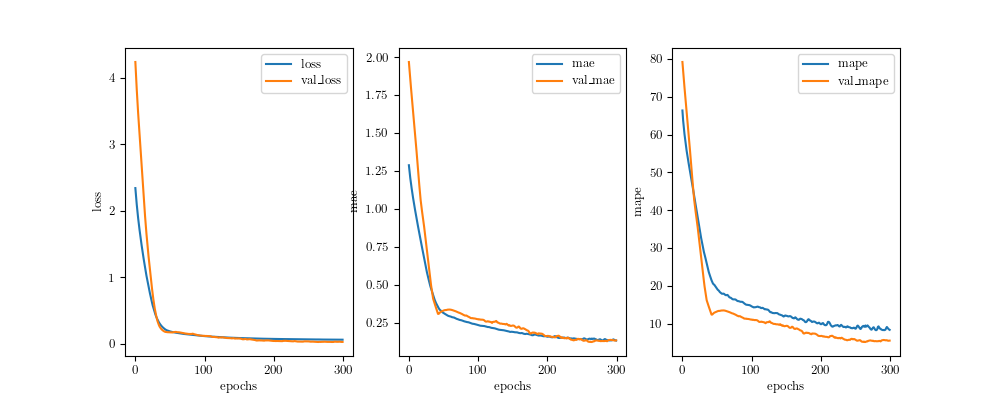

In [25]:
plot_history_info(history)

In [26]:
dnn_model.evaluate(test_features, test_labels)

1/1 [==============================] - 0s 27ms/step - loss: 0.0283 - mae: 0.1364 - mape: 5.4972


[0.028315020725131035, 0.13641509413719177, 5.497154235839844]

In [27]:
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 5)                11        
 n)                                                              
                                                                 
 dense (Dense)               (None, 16)                96        
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 124
Trainable params: 113
Non-trainable params: 11
_________________________________________________________________


In [28]:
dataset.columns

Index(['revenue', 'media1_S', 'media2_S', 'media3_S', 'competitor_sales',
       'newsletter'],
      dtype='object')

In [29]:
test_fea_pd = pd.DataFrame(data = test_features, 
                  columns = ['media1_S', 'media2_S', 'media3_S', 'competitor_sales',
       'newsletter'])

In [30]:
test_fea_pd.columns

Index(['media1_S', 'media2_S', 'media3_S', 'competitor_sales', 'newsletter'], dtype='object')

In [31]:
def feature_permutation(feature, X_test, y_test, model):
    """ compute a list of permutation related to one feature
    with multiple random permutations
    """
    permutations = []
    base_error = model.evaluate(X_test, y_test)[0]
    
    # loss be the first item ...
    def loss_change(X, y, base):
        return np.abs(model.evaluate(X, y, verbose=0)[0] - base)

    # compute for 50 times ...
    for i in tqdm.tqdm(np.arange(1000)):
        X_test[feature] = np.random.permutation(X_test[feature].values)
        permutations.append(loss_change(X_test, y_test, base_error))
    
    return permutations

In [32]:
def feature_importance(X_test, y_test, model):
    """ loop over all the features """
    
    perms = [feature_permutation(col, X_test, y_test, model) for col in X_test.columns]
    
    means = [np.mean(perm) for perm in perms]
    
    fig, ax = plt.subplots()
    ax.barh(X_test.columns, means)

    ax.set_xlabel('feature importance (loss:mse)')

In [33]:
# # example of computing the permutation of only one feature

# aggrement_pers = feature_permutation(
#     feature='media1_S', 
#     X_test=test_fea_pd, 
#     y_test=test_labels, 
#     model=dnn_model)

1/1 [==============================] - 0s 125ms/step - loss: 0.0283 - mae: 0.1364 - mape: 5.4972


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:04<00:00, 15.41it/s]


1/1 [==============================] - 0s 34ms/step - loss: 0.0358 - mae: 0.1623 - mape: 6.6398


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:04<00:00, 15.44it/s]


1/1 [==============================] - 0s 33ms/step - loss: 0.0745 - mae: 0.2148 - mape: 8.6276


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:05<00:00, 15.34it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0193 - mae: 0.1276 - mape: 5.0693



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:05<00:00, 15.19it/s]

1/1 [==============================] - ETA: 0s - loss: 0.0817 - mae: 0.2239 - mape: 9.1890

1/1 [==============================] - 0s 33ms/step - loss: 0.0817 - mae: 0.2239 - mape: 9.1890


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:05<00:00, 15.26it/s]


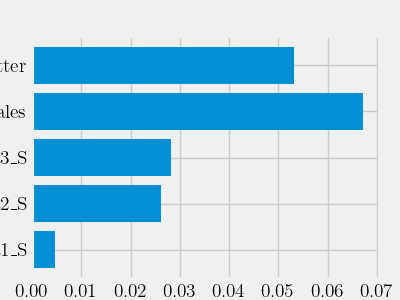

In [34]:

with plt.style.context('fivethirtyeight'):
    feature_importance( 
    X_test=test_fea_pd, 
    y_test=test_labels, 
    model=dnn_model)
save2Vis('DNN_feature_importance')

### an aleatoric DNN model that computes `data noise`

In [ ]:
aleatoric_model = create_and_compile_aleatoric_model(
                        input_shape = 5, 
                        norm = normalizer)

In [ ]:
history_aleatoric = aleatoric_model.fit(
    train_features,
    train_labels,
    # validation_split=0.2,
    validation_data=(test_features, test_labels),
    verbose=0,
    epochs=300)

In [ ]:
plot_history_info(history_aleatoric)

In [ ]:
# # changing between calls
# aleatoric_model.evaluate(test_features, test_labels)

In [ ]:
aleatoric = AleatoricPredict(test_features, test_labels)

In [ ]:
aleatoric.predict_dist(model=aleatoric_model)

In [ ]:
val_performance['aleatoric_model'] = aleatoric.cp_metrics()

In [ ]:
aleatoric.pl_aleatoric_uncertainty(val_x_axis)
# save2Vis('DNN_aleatoric')

### Flipout model

In [ ]:
flipout_model = BDNN_flipout(N=200, norm=normalizer)

In [ ]:
flipout_model.compile(
    loss=nll, 
    optimizer='RMSprop',
    metrics=[tf.keras.metrics.MeanAbsoluteError(name='mae'),
            tf.keras.metrics.MeanAbsolutePercentageError(name='mape')])

history_flipout = flipout_model.fit(
                    train_features,
                    train_labels,
                    epochs=300,
                    # validation_split=0.2,
                    validation_data=(train_features, train_labels),
                    verbose=0)

In [ ]:
plot_history_info(history_flipout)
# save2Vis('learning_curveBDNN')

In [ ]:
# # Bayesian changing each time
# flipout_model.evaluate(train_features, train_labels)

In [ ]:
ensemble = EnsemblePredict(ensemble_size=300, test_features = test_features, test_labels=test_labels)

In [ ]:
# epistemic uncertainty compute the ensemble times of conditional mean 
ensemble.mc_predict_test_set(model=flipout_model)

In [ ]:
# plot the epistemic uncertainty 
ensemble.pl_epistemic(val_x_axis = val_x_axis)

In [ ]:
ensemble.pl_residual_B(low=2, limit=3)
# save2Vis('residual_plot')

In [ ]:
ensemble.pl_epistemic_ts(dataset=dataset)
# save2Vis('BDNN_epistemic_uncertainty')

In [ ]:
val_performance['flipout_model'] = ensemble.cp_ensemble_metrics()

In [ ]:
val_performance['flipout_model']

In [ ]:
# mixed uncertainty: compute the distribution objects throughout the test set for 

ensemble.cp_ensemble_testset(flipout_model)

In [ ]:
# compute the GMM bounds given dist objects

PI_dp_bounds_all_list = ensemble.get_PI_bounds_testset(style='gmm')

In [ ]:
PI_dp_bounds_all_list[0].mean

In [ ]:
ensemble.mixed_uncertainty_PI(dataset, PI_dp_bounds_all_list, val_x_axis)
# save2Vis('mixed_uncertainty')

### `PYMC` Bayesian linear regression model

In [ ]:
RANDOM_SEED = 9527
rng = np.random.default_rng(RANDOM_SEED)

In [ ]:
# normalized features
n_train_features, n_test_features, train_labels, test_labels = base_process_data(dataset=dataset, split_index=200, normalize=True)

In [ ]:
train_labels.shape

In [ ]:
n_train_features.shape

In [ ]:
with Model() as model:  # model specifications in PyMC are wrapped in a with-statement
    # Define priors
    sigma = Normal("sigma", 0, sigma=10)
    
    b1 = Normal("media1_S", 0, sigma=1)
    b2 = Normal("media2_S", 0, sigma=1)
    b3 = Normal("media3_S", 0, sigma=1)
    b_cs = Normal("competitor_sales", 0, sigma=1)
    b_nl = Normal("newsletter", 0, sigma=1)
    bias = Normal("bias", 0, sigma=1)

    # Define likelihood
    likelihood = Normal("revenue", 
                        mu = bias +b1*n_train_features[:,0]+b2*n_train_features[:,1]+b3*n_train_features[:,2]+b_cs*n_train_features[:,3]+b_nl*n_train_features[:,4], 
                        sigma=sigma, 
                        observed=train_labels)

    # Inference!
    # draw 3000 posterior samples using NUTS sampling
    idata = sample(5000)

In [ ]:
az.plot_trace(idata, combined=True, figsize=(12, 24));

In [ ]:
idata

## temporal models

I'll try a `Bayesian LSTM model` first and a few some other state-of-the-art alternatives for illustration.

Note that this will have a different processing procedure than base models.

In [ ]:
dataset.head()

In [ ]:
''' for plotting of `periodicity` '''

index_time = np.arange(1, len(dataset)+1)

# back-up
monthly = sin_transformer(period=4, x=index_time)
yearly = sin_transformer(period=4*12, x=index_time)

# periodicity display

fig, ax = plt.subplots()
ax.plot(monthly, label = 'monthly periodicity')
ax.plot(dataset['revenue'], label='revenue in millions')
ax.plot(yearly, label = 'yearly periodicity')

ax.set_xlabel('Time')
ax.set_ylabel('Revenue')
ax.legend()
ax.set_xlim([0, 200])
# save2Vis('periodicity')

In [ ]:
from darts import TimeSeries
from darts.utils.statistics import plot_acf, check_seasonality

In [ ]:
ts_revenue = TimeSeries.from_series(dataset['revenue']) 

In [ ]:
plt.figure()
ts_revenue.plot()

In [ ]:
plot_acf(ts_revenue, m=48, alpha=0.05, max_lag=60)

In [ ]:
for m in range(2, 52):
    is_seasonal, period = check_seasonality(ts_revenue, m=m, alpha=0.05, max_lag=60)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

In [ ]:
train_df, val_df = temporal_process_data(dataset, split_index=200)

In [ ]:
# weekly context length
context_length = 4

cr_window = WindowGenerator(
    input_width=context_length,
    label_width=1,
    shift=1,
    label_columns=['revenue'], 
    train_df=train_df,
    val_df = val_df)

cr_window

In [ ]:
print("shape hint:")
print("input shape:", cr_window.example[0].shape)
print("output shape:", cr_window.example[1].shape)

In [ ]:
# check the seasonality with ACF 

#### a comparative DNN test

In [ ]:
def DNN_wo_normalization():
    model = tf.keras.Sequential([
      tf.keras.layers.Dense(16, activation='relu'),
      tf.keras.layers.Dense(2, activation='relu'),
      tf.keras.layers.Dense(1)
    ])
    return model

In [ ]:
DNN_wn = DNN_wo_normalization()

In [ ]:
history = compile_and_fit_lstm(
    model = DNN_wn, 
    loss = tf.keras.losses.MeanSquaredError(), 
    window=cr_window, 
    EPOCHS = 300,
    VERBOSE = 0)

In [ ]:
dnn_result_dict = cp_val(DNN_wn, cr_window, train_df, val_df)

### deterministic LSTM

In [ ]:
# get a LSTM model herein

lstm_model = build_lstm()

In [ ]:
history = compile_and_fit_lstm(
    model = lstm_model, 
    loss = tf.keras.losses.MeanSquaredError(), 
    window=cr_window, 
    EPOCHS=300,
    VERBOSE=0)

In [ ]:
plot_history_info(history)

In [ ]:
# # # this may not work due to the very small size of val data
# lstm_model.evaluate(cr_window.val)

In [ ]:
val_performance['lstm_model'] = cr_window.cp_val_lstm_mcdropout_oneshot(lstm_model)
val_performance['lstm_model']

### Stochastic Regularisation technique

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
lstm_SRT = lstm_SRT(units=16)

In [ ]:
history_Blstm2 = compile_and_fit_lstm(
    model=lstm_SRT, 
    window = cr_window, 
    loss = 'mse', 
    EPOCHS=300,
    VERBOSE=0)

In [ ]:
cr_window.cp_val_lstm_mcdropout_oneshot(model=lstm_SRT)

In [ ]:
ensemble_results, val_performance['Blstm_model'] = cr_window.cp_val_B(
    model=lstm_SRT, ensemble_size=100, style='mc_dropout')

In [ ]:
val_performance['Blstm_model']

In [ ]:
cr_window.display_lstm_val(ensemble_results, val_x_axis)
save2Vis('BLSTM_epistemic_uncertainty')

### svi LSTM model

In [ ]:
B_lstm_model = build_BLSTM_svi(latent_dim=64, KL_scaling_factor=200)

In [ ]:
history_Blstm = compile_and_fit_lstm(
    model=B_lstm_model, 
    window = cr_window, 
    loss = nll, 
    EPOCHS=500,
    VERBOSE=0)

In [ ]:
plot_history_info(history_Blstm)

In [ ]:
# check the input 
for ex_input, ex_output in cr_window.val.take(1):
    print("training dp input:", ex_input.shape)
    print("training dp output:", ex_output.shape)

In [ ]:
ensemble_results = cr_window.cp_val(model = B_lstm_model, ensemble_size=300)

In [ ]:
# specifically, now the gt value is the normalized 'revenue' shown only in `val_df`

In [ ]:
# add the predictions then 
fig, ax = plt.subplots()
ax.scatter(val_x_axis, val_df['revenue'], color='r', marker='o')
ax.scatter(val_x_axis, test_preds, color='b', marker='x')
# plt.xlim([0, 4])